In [1]:
from catboost import CatBoostClassifier, Pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
    cross_validate
)
from catboost.utils import get_confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, accuracy_score


## Load the data

In [3]:
# X = pd.read_csv("genus_relative_abundance.csv", sep=";")
X = pd.read_csv("species_relative_abundance.csv", sep=";")
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Class"]
X = X.set_index("Sample", drop=True)
print(X.shape)
assert X.shape[0] == y.shape[0]

(212, 1128)


## Split into train / test sets

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# train_pool = cb.Pool(data=X_train, label=y_train)
# test_pool = cb.Pool(data=X_test, label=y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

full_pool = cb.Pool(data=X, label=y)
# full_pool_10_features = cb.Pool(data=X[summary_10['selected_features_names']], label=y)
train_pool = cb.Pool(data=X_train, label=y_train)
eval_pool = cb.Pool(data=X_eval, label=y_eval)
test_pool = cb.Pool(data=X_test, label=y_test)

## Select Features

In [71]:
def select_n_features(estimator, train_pool, eval_pool, n_features_to_select=100):
  return estimator.select_features(
    X=train_pool,
    eval_set=eval_pool,
    features_for_select=list(range(train_pool.num_col())),
    num_features_to_select=n_features_to_select,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level='Silent',
  )["selected_features_names"]

In [13]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

clf_all_features = cb.CatBoostClassifier(thread_count=-1,iterations=100, loss_function='Logloss', custom_metric=['F1', 'AUC', 'Accuracy'], eval_metric='AUC', verbose=False)
clf_100 = cb.CatBoostClassifier(thread_count=-1,iterations=100, loss_function='Logloss', custom_metric=['F1', 'AUC', 'Accuracy'], eval_metric='AUC', verbose=False)
clf_50 = cb.CatBoostClassifier(thread_count=-1,iterations=100, loss_function='Logloss', custom_metric=['F1', 'AUC', 'Accuracy'], eval_metric='AUC', verbose=False)
clf_10 = cb.CatBoostClassifier(thread_count=-1,iterations=100, loss_function='Logloss', custom_metric=['F1', 'AUC', 'Accuracy'], eval_metric='AUC', verbose=False)

clf_all_features.fit(train_pool)

summary_100 = clf_100.select_features(
    train_pool,
    eval_set=eval_pool,
    features_for_select=list(range(train_pool.num_col())),
    num_features_to_select=100,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
)

summary_50 = clf_50.select_features(
    train_pool,
    eval_set=eval_pool,
    features_for_select=list(range(train_pool.num_col())),
    num_features_to_select=50,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
)

summary_10 = clf_10.select_features(
    train_pool,
    eval_set=eval_pool,
    features_for_select=list(range(train_pool.num_col())),
    num_features_to_select=10,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
)


In [281]:
clf_5 = cb.CatBoostClassifier(thread_count=-1,iterations=10000, loss_function='Logloss', custom_metric=['F1', 'AUC', 'Accuracy'], eval_metric='AUC', verbose=False)

summary_5 = clf_5.select_features(
    train_pool,
    eval_set=eval_pool,
    features_for_select=list(range(train_pool.num_col())),
    num_features_to_select=5,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
)


## Evaluate the models

In [ ]:
# clf_100.compare(clf_10, test_pool, ['F1', 'AUC', 'Accuracy'])
# clf_100.compare(clf_50, test_pool, ['F1', 'AUC', 'Accuracy'])
# clf_50.compare(clf_100, test_pool, ['F1', 'AUC', 'Accuracy'])

In [303]:
print(get_confusion_matrix(model=clf_100, data=test_pool, thread_count=-1))
print(get_confusion_matrix(model=clf_50, data=test_pool, thread_count=-1))
print(get_confusion_matrix(model=clf_10, data=test_pool, thread_count=-1))
print(get_confusion_matrix(model=clf_5, data=test_pool, thread_count=-1))

[[16.  7.]
 [ 5. 15.]]
[[20.  3.]
 [ 4. 16.]]
[[17.  6.]
 [ 2. 18.]]
[[15.  8.]
 [ 3. 17.]]


In [304]:
clf_all_features_metrics_eval = clf_all_features.eval_metrics(data=test_pool, metrics=['AUC', 'Accuracy', 'F1'])
clf_100_metrics_eval = clf_100.eval_metrics(data=test_pool, metrics=['AUC', 'Accuracy', 'F1'])
clf_50_metrics_eval = clf_50.eval_metrics(data=test_pool, metrics=['AUC', 'Accuracy', 'F1'])
clf_10_metrics_eval = clf_10.eval_metrics(data=test_pool, metrics=['AUC', 'Accuracy', 'F1'])
clf_5_metrics_eval = clf_5.eval_metrics(data=test_pool, metrics=['AUC', 'Accuracy', 'F1'])

clf_all_features_metrics_eval_df = pd.DataFrame([clf_all_features_metrics_eval]).melt().explode('value')
clf_100_metrics_eval_df = pd.DataFrame([clf_100_metrics_eval]).melt().explode('value')
clf_50_metrics_eval_df = pd.DataFrame([clf_50_metrics_eval]).melt().explode('value')
clf_10_metrics_eval_df = pd.DataFrame([clf_10_metrics_eval]).melt().explode('value')
clf_5_metrics_eval_df = pd.DataFrame([clf_5_metrics_eval]).melt().explode('value')

clf_all_features_metrics_eval_df['n_features'] = 'All features'
clf_100_metrics_eval_df['n_features'] = '100 features'
clf_50_metrics_eval_df['n_features'] = '50 features'
clf_10_metrics_eval_df['n_features'] = '10 features'
clf_5_metrics_eval_df['n_features'] = '5 features'

compare_100_50_10_metric_scores = pd.concat([clf_all_features_metrics_eval_df, clf_100_metrics_eval_df, clf_50_metrics_eval_df, clf_10_metrics_eval_df, clf_5_metrics_eval_df], ignore_index=True)
compare_100_50_10_metric_scores.head()

,variable,value,n_features
0,AUC,0.470652,All features
1,AUC,0.46413,All features
2,AUC,0.518478,All features
3,AUC,0.619565,All features
4,AUC,0.591304,All features


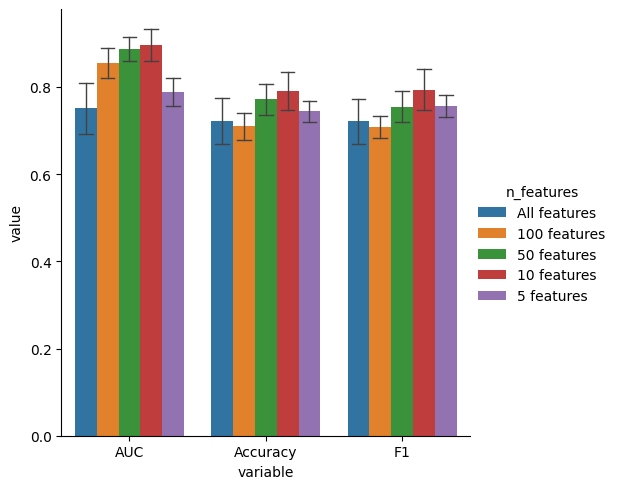

In [305]:
# sns.barplot(clf_50_metrics_eval['AUC'], )

sns.catplot(
  data=compare_100_50_10_metric_scores,
  estimator='mean',
  errorbar='sd',
  x='variable',
  y='value',
  hue='n_features',
  kind='bar',
  errwidth=1,
  capsize=0.1,
  orient='v',
)

In [314]:
get_confusion_matrix(model=clf, data=test_pool, thread_count=-1)
# cb.eval_metrics(data=test_pool,
#              metrics=['F1', 'AUC', 'Accuracy'],)
clf_10.get_params()

{'iterations': 100,
 'loss_function': 'Logloss',
 'verbose': False,
 'custom_metric': ['F1', 'AUC', 'Accuracy'],
 'eval_metric': 'AUC'}

In [396]:
cv_params = {
  'iterations': 1000,
  'loss_function': 'Logloss',
  'verbose': False,
  'custom_metric': ['F1', 'AUC', 'Accuracy'],
  'eval_metric': 'F1',
  'l2_leaf_reg': 3,
  'subsample': 0.7,
  'depth': 3.0,
  'learning_rate': 0.05
}

cv_scores = cb.cv(
  pool=full_pool,
  params=cv_params,
  fold_count=10,
  plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.8181818182
bestIteration = 169

Training on fold [1/10]

bestTest = 0.8421052632
bestIteration = 286

Training on fold [2/10]

bestTest = 0.9090909091
bestIteration = 0

Training on fold [3/10]

bestTest = 0.8
bestIteration = 152

Training on fold [4/10]

bestTest = 0.9565217391
bestIteration = 155

Training on fold [5/10]

bestTest = 0.75
bestIteration = 1

Training on fold [6/10]

bestTest = 0.7619047619
bestIteration = 279

Training on fold [7/10]

bestTest = 0.8
bestIteration = 233

Training on fold [8/10]

bestTest = 0.8421052632
bestIteration = 164

Training on fold [9/10]

bestTest = 0.8695652174
bestIteration = 19



In [398]:
print(cv_scores['test-F1-mean'].values.argmax(), cv_scores['test-AUC-mean'].values.argmax(), cv_scores['test-Accuracy-mean'].values.argmax())
# cv_scores['test-F1-mean'].max()
print(cv_scores['test-F1-mean'].max(), cv_scores['test-AUC-mean'].max(), cv_scores['test-Accuracy-mean'].max())

548 536 548
0.7919040189406322 0.8529173553719008 0.7918181818181818


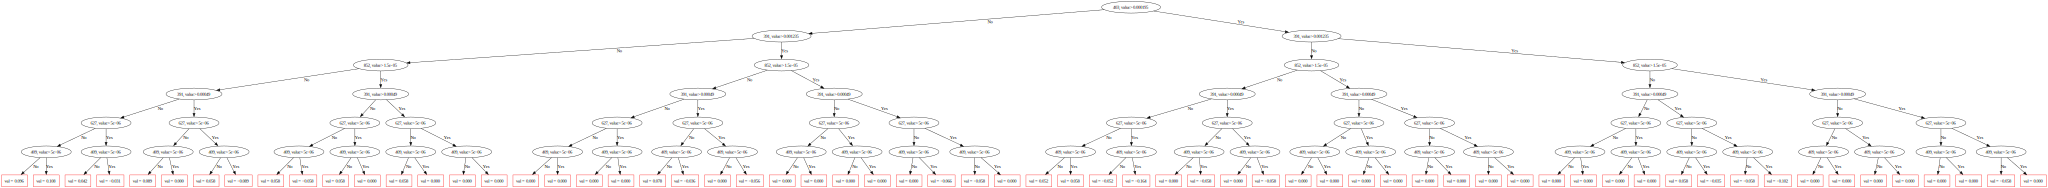

In [401]:
clf_10.plot_tree(
  tree_idx=0,
)

In [359]:
from scipy.stats import randint, uniform

rs_model = cb.CatBoostClassifier(
    thread_count=-1,
    loss_function="Logloss",
    custom_metric=["F1", "Accuracy"],
    verbose=False,
)
rs_param_distributions = {
    "learning_rate": uniform(0.01, 1.0),
    "depth": randint(1, 20),
    "subsample": uniform(0.6, 0.4),
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
random_search = rs_model.randomized_search(
    rs_param_distributions,
    full_pool_10_features,
    cv=10,
    n_iter=10,
    calc_cv_statistics=True,
    train_size=0.8,
    verbose=False,
)


bestTest = 0.4686348272
bestIteration = 10


bestTest = 0.5011900181
bestIteration = 6


bestTest = 0.5394195514
bestIteration = 2


bestTest = 0.5160876379
bestIteration = 32


bestTest = 0.4500525665
bestIteration = 11


bestTest = 0.4528615326
bestIteration = 165


bestTest = 0.4813960797
bestIteration = 7


bestTest = 0.6268483347
bestIteration = 3


bestTest = 0.4565631784
bestIteration = 37


bestTest = 0.4646152314
bestIteration = 51

Training on fold [0/10]

bestTest = 0.3986721394
bestIteration = 79

Training on fold [1/10]

bestTest = 0.6144291585
bestIteration = 13

Training on fold [2/10]

bestTest = 0.2946009832
bestIteration = 41

Training on fold [3/10]

bestTest = 0.3787042852
bestIteration = 79

Training on fold [4/10]

bestTest = 0.3300721043
bestIteration = 22

Training on fold [5/10]

bestTest = 0.5293869451
bestIteration = 4

Training on fold [6/10]

bestTest = 0.5744126361
bestIteration = 10

Training on fold [7/10]

bestTest = 0.1991709054
bestIteration = 38

Tr

In [361]:
random_search['params']

{'l2_leaf_reg': 5,
 'subsample': 0.702893243824638,
 'depth': 3.0,
 'learning_rate': 0.33703745324930223}

In [9]:
# y_pred_clf10 = clf_10.predict(X_test)


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X=X, y=y, test_size=0.2):
    print(train_index, test_index)
# num_fea = 100 
# X_train = X_train[:, idx[0:num_fea]]
# for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
#     rf.fit(features[train_index], y[train_index])
#     y_pred = rf.predict(features[test_index])
#     get_results(y_pred, y[test_index])

TypeError: split() got an unexpected keyword argument 'test_size'

## Mess cross_val_score

In [68]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

clf_10 = cb.CatBoostClassifier(thread_count=-1,iterations=100, loss_function='Logloss', eval_metric='F1', verbose=False)

# summary_10 = clf_10.select_features(
#     train_pool,
#     eval_set=eval_pool,
#     features_for_select=list(range(train_pool.num_col())),
#     num_features_to_select=10,
#     steps=10,
#     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
#     shap_calc_type=EShapCalcType.Regular,
#     train_final_model=True,
#     logging_level='Silent',
# )


In [55]:
clf_10.fit(train_pool)


In [95]:
params = {
  "thread_count": 8,
  "iterations": 1000,
  "loss_function": 'Logloss',
  "eval_metric": 'AUC',
  "custom_metric": ['F1', 'AUC', 'Accuracy'],
  "verbose": False
}
full_pool_10_features = cb.Pool(data=X[selected_features], label=y)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cb.cv(
  pool=full_pool,
  params=params,
  folds=skf,
  plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.8595041322
bestIteration = 19

Training on fold [1/10]

bestTest = 0.958677686
bestIteration = 126

Training on fold [2/10]

bestTest = 0.7454545455
bestIteration = 818

Training on fold [3/10]

bestTest = 0.9181818182
bestIteration = 291

Training on fold [4/10]

bestTest = 0.8818181818
bestIteration = 413

Training on fold [5/10]

bestTest = 0.8545454545
bestIteration = 2

Training on fold [6/10]

bestTest = 0.8909090909
bestIteration = 13

Training on fold [7/10]

bestTest = 0.9363636364
bestIteration = 420

Training on fold [8/10]

bestTest = 1
bestIteration = 264

Training on fold [9/10]

bestTest = 0.7272727273
bestIteration = 1



In [101]:
cv_scores.loc[cv_scores_10_f['test-AUC-mean'].argmax()]

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

NameError: name 'XGBClassifier' is not defined

In [100]:
cv_scores = cross_val_score(estimator=clf_10, X=X, y=y, scoring='roc_auc', cv=skf)
cv_scores.mean(), cv_scores.std()

(0.7693984962406015, 0.0675777206218529)

In [54]:
f1_score(clf_10.predict(test_pool), y_test)

0.7727272727272727

## Hype tuning

In [63]:
learning_rate	ContinuousParameterRanges	MinValue: 0.001, MaxValue: 0.01
depth	IntegerParameterRanges	MinValue: 4, MaxValue: 10
l2_leaf_reg	IntegerParameterRanges	MinValue: 2, MaxValue: 10
random_strength	ContinuousParameterRanges	MinValue: 0, MaxValue: 10
param_distributions = {
  "learning_rate": np.linspace(),
  "depth": np.randint(),
  "l2_leaf_reg": np.randint(),
  "random_strength": np.linspace(),
    
}

SyntaxError: invalid syntax (3297765776.py, line 1)

In [72]:
selected_features = select_n_features(estimator=clf_10, train_pool=train_pool, eval_pool=eval_pool, n_features_to_select=10)

In [73]:
selected_features

['UMGS1670',
 'CAG-274',
 'Ruminococcus_C',
 'UMGS1889',
 'CAG-272',
 'CAG-475',
 'HGM11417',
 'UBA733',
 'CAG-449',
 'WRGP01']